In [106]:
import random
import math
import itertools as it

import matplotlib

font = {'family': 'normal',
        'weight': 'normal',
        'size': 14}

matplotlib.rc('font', **font)
import enum
import matplotlib.pyplot as plt
import numpy as np
import igraph as ig
from tqdm import tqdm
import geopandas as gpd
import pandas as pd
import math
import statsmodels.api as sm
from typing import Tuple, List
from copy import copy
import pygad
from inequality.gini import Gini
from inequality.theil import TheilD
pd.options.mode.chained_assignment = None

In [107]:
g = ig.load('/home/rico/Documents/thesis/eda/notebooks/synthetic_dataset_0/graph.gml')
census = gpd.read_file('/home/rico/Documents/thesis/eda/notebooks/synthetic_dataset_0/census_data.geojson')

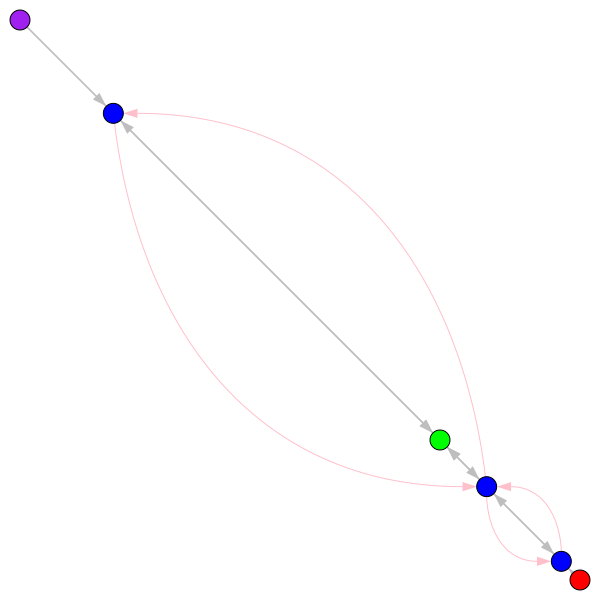

In [111]:
ig.plot(g)

In [112]:
census

,neighborhood,n_inh,n_purple,n_red,geometry
0,RC1,1000,1000,0,POINT (0.50000 0.50000)
1,RC2,100,0,100,POINT (3.50000 3.50000)


# Helper Functions

In [113]:
class TravelMetric(enum.Enum):
    TT = 'tt'
    HOPS = 'hops'
    COM = 'com'

In [114]:
g.vs.select(type_eq='res_node')['name']

['RC1', 'RC2']

In [115]:
def evaluate_graph(g: ig.Graph, MAX_EDGES: int = 100) -> pd.DataFrame:
    nb_nodes = g.vs.select(type_eq='res_node')
    poi_nodes = g.vs.select(type_eq='poi_node')

    tt_mx = np.zeros((len(nb_nodes), len(poi_nodes)))
    hops_mx = np.zeros((len(nb_nodes), len(poi_nodes)))

    failed = {}

    for i, o in enumerate(nb_nodes):
        for j, d in enumerate(poi_nodes):
            # Travel Time
            tt = g.shortest_paths(o, d, weights='tt')[0][0]
            if tt == math.inf:
                if not failed.get(f"{o['node_id']}_tt", None) == d['node_id']:
                    failed[f"{o['node_id']}_tt"] = d["node_id"]
            else:
                tt_mx[i, j] = tt
            # Number of hops
            edges = g.get_shortest_paths(o, d, weights='tt', output='epath')[0]
            if edges == math.inf or not edges:
                if not failed.get(f"{o['node_id']}_edges", None) == d["node_id"]:
                    failed[f"{o['node_id']}_edges"] = d["node_id"]
            else:
                hops_mx[i, j] = len(edges) if len(edges) > 0 else MAX_EDGES

    df_tt = pd.DataFrame(tt_mx, columns=poi_nodes['name'])
    df_tt['metric'] = 'travel_time'
    df_tt['rc'] = nb_nodes['name']

    df_hops = pd.DataFrame(hops_mx, columns=poi_nodes['name'])
    df_hops['metric'] = 'hops'
    df_hops['rc'] = nb_nodes['name']

    return pd.concat([df_tt, df_hops], axis=0)

In [116]:
df = evaluate_graph(g)
df

,POI1,metric,rc
0,13.152186,travel_time,RC1
1,8.061017,travel_time,RC2
0,3.000000,hops,RC1
1,3.000000,hops,RC2


In [117]:
def generate_samples(metric_df: pd.DataFrame, inh_per_group: pd.DataFrame) -> pd.DataFrame:
    merged_df = pd.merge(metric_df, inh_per_group, how='left', left_on='rc', right_on='neighborhood')

    city = pd.DataFrame(columns=['metric_value', 'group'])

    for group in merged_df.loc[:, merged_df.columns.str.contains('n_')].columns:
        samples_group = np.repeat(merged_df['average'].values, merged_df[group])
        samples_group = samples_group.reshape((-1, 1))
        labels = np.repeat(group.replace('n_', ''), samples_group.shape[0]).reshape((-1, 1))
        group_individuals = np.hstack([samples_group, labels])
        df = pd.DataFrame(group_individuals, columns=['metric_value', 'group'])
        city = pd.concat([city, df], axis=0)

    return city

In [118]:
def get_tt_hops_com_dfs(g: ig.Graph, census_data: pd.DataFrame, COM_THRESHOLD: float) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    metric_df = evaluate_graph(g)
    groups_census = census_data.drop(columns=['n_inh', 'geometry'])

    metric_df['average'] = metric_df.loc[:, metric_df.columns.str.contains('POI')].mean(axis=1)
    tt_samples = generate_samples(metric_df[metric_df['metric'] == 'travel_time'], groups_census)
    hops_samples = generate_samples(metric_df[metric_df['metric'] == 'hops'], groups_census)

    value_cols = metric_df.loc[:, metric_df.columns.str.contains('POI')]
    metric_df['average'] = (value_cols < COM_THRESHOLD).sum(axis=1)
    com_samples = generate_samples(metric_df[metric_df['metric'] == 'travel_time'], groups_census)

    return tt_samples, hops_samples, com_samples

In [119]:
def series_min_max_norm(sr: pd.Series):
    return (sr - sr.min()) / (sr.max() - sr.min())

# Reward Functions

In [120]:
def egalitarian(g: ig.Graph, census_data: gpd.GeoDataFrame, COM_THRESHOLD: float=12,
                        metrics: List[TravelMetric] = [TravelMetric.TT, TravelMetric.HOPS, TravelMetric.COM],
                        groups: List[str] = None) -> float:
    tt_samples, hops_samples, com_samples = get_tt_hops_com_dfs(g, census_data, COM_THRESHOLD)
    metrics_values = {
        TravelMetric.TT.value: tt_samples,
        TravelMetric.HOPS.value: hops_samples,
        TravelMetric.COM.value: com_samples
    }
    metrics_names = [t.value for t in metrics]
    metrics_values = {metrics_name: metrics_values[metrics_name] for metrics_name in metrics_names}

    groups = list(tt_samples.group.unique()) if not groups else groups

    assert isinstance(groups, list)

    # fit KDE (sklearn) on each component
    kdes = {group: {metric: None for metric in metrics_names} for group in groups}
    kde_mixtures = {metric: None for metric in metrics_names}

    fig, ax = plt.subplots(figsize=(10,10))

    for group in groups:
        for metric, metrics_values_key in zip(metrics_names, metrics_values):
            metric_df = metrics_values[metrics_values_key]
            X = metric_df[metric_df.group == group].drop(columns='group').astype(float).to_numpy()
            print(group, np.unique(X, return_counts=True))
            kde = sm.nonparametric.KDEUnivariate(X)
            kde.fit(bw=0.2)
            kdes[group][metric] = kde
            ax.plot(kde.support, kde.density, lw=3, label=f"KDE {group} {metric}", zorder=10, color=group)
            ax.scatter(
                X,
                np.abs(np.random.randn(X.size)) / 40,
                marker="x",
                color=group,
                zorder=20,
                # label="Samples",
                alpha=0.5,
            )
            ax.legend(loc="best")
            ax.grid(True, zorder=-5)

    for metric, metrics_values_key in zip(metrics_names, metrics_values):
        metric_df = metrics_values[metrics_values_key]
        X = metric_df.drop(columns='group').astype(float).to_numpy()
        kde = sm.nonparametric.KDEUnivariate(X)
        kde.fit(bw=0.2)
        kde_mixtures[metric] = kde

    reward = 0
    for metric in metrics_names:
        n_dist = len(kdes.keys())
        reward += kde_mixtures[metric].entropy - 1 / n_dist * sum([kdes[group][metric].entropy for group in kdes])

    return -reward

In [121]:
def egalitarian_theil(g: ig.Graph, census_data: gpd.GeoDataFrame, COM_THRESHOLD: float=12,
                        metrics: List[TravelMetric] = [TravelMetric.TT, TravelMetric.HOPS, TravelMetric.COM],
                        groups: List[str] = None) -> float:
    tt_samples, hops_samples, com_samples = get_tt_hops_com_dfs(g, census_data, COM_THRESHOLD)
    metrics_values = {
        TravelMetric.TT.value: tt_samples,
        TravelMetric.HOPS.value: hops_samples,
        TravelMetric.COM.value: com_samples
    }
    metrics_names = [t.value for t in metrics]
    metrics_values = {metrics_name: metrics_values[metrics_name] for metrics_name in metrics_names}

    groups = list(tt_samples.group.unique()) if not groups else groups

    assert isinstance(groups, list)

    # fit KDE (sklearn) on each component
    theil_inequality = {metric: None for metric in metrics_names}

    for metric, metrics_values_key in zip(metrics_names, metrics_values):
        metric_df = metrics_values[metrics_values_key]
        X = metric_df.drop(columns='group').astype(float).to_numpy()
        Y = metric_df.group
        theil_inequality[metric] = TheilD(X,Y).T

    return -sum([theil_inequality[k] for k in theil_inequality])

purple (array([13.15218613]), array([1000]))
purple (array([3.]), array([1000]))
red (array([8.06101731]), array([100]))
red (array([3.]), array([100]))


-0.304636097346335

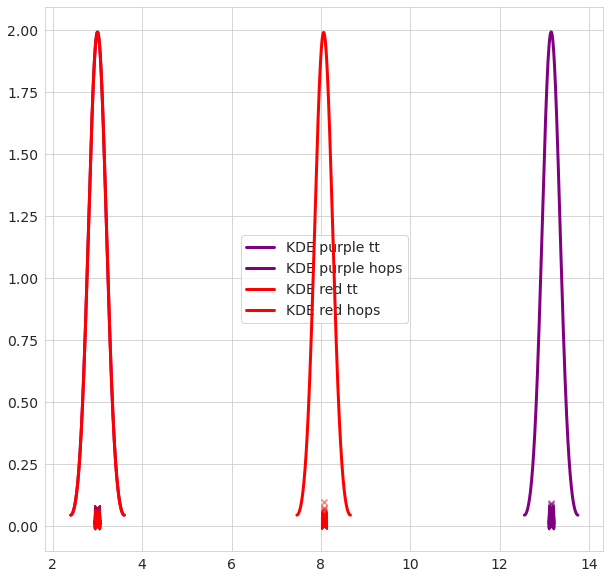

In [122]:
egalitarian(g, census, metrics=[TravelMetric.TT, TravelMetric.HOPS])

# Analysis
## Trying to remove an edge

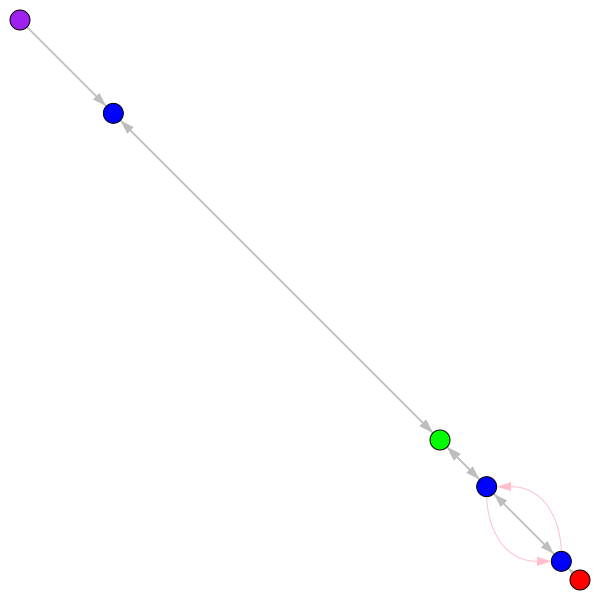

In [128]:
g_purple_bad = g.copy()
edges = g_purple_bad.es.select(type_eq='bus')
g_purple_bad.delete_edges(edges[0:2])
ig.plot(g_purple_bad)


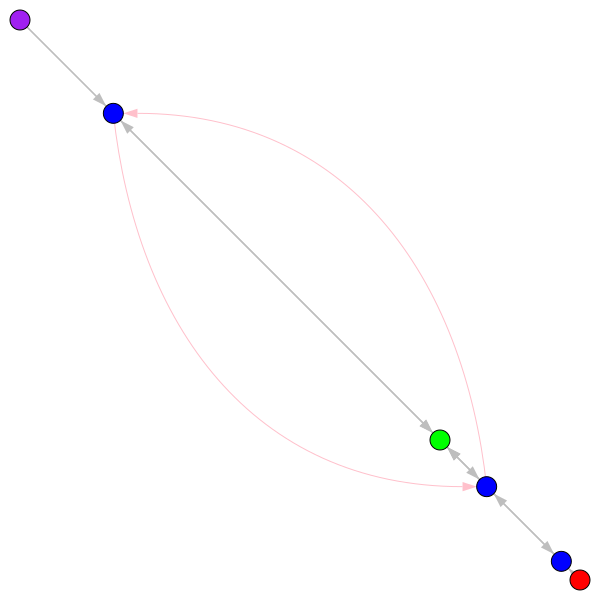

In [129]:
g_red_bad = g.copy()
edges = g_red_bad.es.select(type_eq='bus')
g_red_bad.delete_edges(edges[2:4])
ig.plot(g_red_bad)

In [130]:
egalitarian_theil(g, census, metrics=[TravelMetric.TT])

array([-0.00755294])

In [131]:
egalitarian_theil(g_purple_bad, census, metrics=[TravelMetric.TT])

array([-0.04226208])

In [132]:
egalitarian_theil(g_red_bad, census, metrics=[TravelMetric.TT])

array([-4.36400125e-05])

In [147]:
kde_1 = sm.nonparametric.KDEUnivariate(np.array([0,0,0,1,1,1]))
kde_1.fit(bw=0.2)
e_1 = kde_1.entropy

kde_2 = sm.nonparametric.KDEUnivariate(np.array([0,0,0,10,10,10]))
kde_2.fit(bw=0.2)
e_2 = kde_2.entropy

kde_3 = sm.nonparametric.KDEUnivariate(np.array([0,0,0,100,100,100]))
kde_3.fit(bw=0.2)
e_3 = kde_3.entropy



0.48544319814752557

0.5026478013244682

0.2513239006622341

In [140]:
TheilD(np.array([0,0,0,10,10,10]),[0,0,0,1,1,1]).wg[0]

-0.6931471805599453

In [138]:
TheilD(np.array([0,0,0,100,100,100]),[0,0,0,1,1,1]).bg[0]

1.3862943611198906

In [136]:
TheilD(np.array([0,0,0,10,10,10]),[0,0,0,1,1,1]).T

0.6931471805599453